In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/mloscratch/homes/yixuan/PDM')

In [3]:
import numpy as np
from datasets import load_dataset
from tqdm import tqdm
from utils.edit_distance import compute_ngram_distance_damerau_levenshtein
from utils.LCS import find_longest_common_substrings
from utils.comon_substring import CommonSubstringMatcher

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset

def get_checkpoints(expr_base_dir):
    """
    Get sorted checkpoints from directory
    
    Parameters
    ----------
    expr_base_dir : str
        Base directory containing checkpoints
        
    Returns
    -------
    list
        Sorted list of (step, consumed) tuples
    """
    return sorted([(int(f.name.split('=')[1].split('-')[0]), int(f.name.split('=')[2]))
                  for f in Path(expr_base_dir).glob("step=*")])

def load_inference_data(base_dir, step, consumed):
    """
    Load inference data from a given step and restore original data order.
    DistributedSampler distributes data in round-robin fashion (e.g., GPU0: [0,8,16,...], GPU1: [1,9,17,...]).
    This function loads data from all rank files and reorders it back to sequential order [0,1,2,...].
    
    Parameters
    ----------
    base_dir : str
        Base directory path 
    step : int
        Training step
    consumed : int
        Number of consumed tokens
        
    Returns
    -------
    Dataset
        HuggingFace dataset with data restored to original sequential order
    """
    file_path = Path(base_dir) / f"step={step}-consumed={consumed}"
    rank_files = sorted(file_path.glob("rank*.jsonl"))
    world_size = len(rank_files)

    # Load data from all ranks
    dataset = load_dataset(
        'json', 
        data_files=[str(f) for f in rank_files], 
        split='train'
    )
    
    total_size = len(dataset)
    items_per_rank = total_size // world_size

    # Reorder to original sequential order
    orig_indices = np.arange(total_size).reshape(world_size, items_per_rank).T.flatten()
    
    return dataset.select(orig_indices)

In [5]:
def calc_avg_lcs_lengths(base_dir, model_ids):
    """
    Calculate average LCS lengths for multiple models with data split into train/val/test
    
    Parameters
    ----------
    base_dir : str
        Base directory containing all model results
    model_ids : list
        List of model identifiers to process
        
    Returns
    -------
    dict
        Dictionary mapping model names to their results with split information
    """
    results = {}
    for model_id in model_ids:
        expr_dir = f"{base_dir}/{model_id}"
        ckpts = get_checkpoints(expr_dir)
        
        steps, avg_lengths = [], []
        for step, consumed in tqdm(ckpts, desc=f"Processing {model_id}"):
            data = load_inference_data(expr_dir, step, consumed)
            
            # Calculate split indices
            n_total = len(data['true_suffix'])
            n_train = int(n_total * 0.9)
            n_val = int(n_total * 0.05)
            
            # Split data
            splits = {
                'train': {
                    'true_suffix': data['true_suffix'][:n_train],
                    'generated_suffix': data['generated_suffix'][:n_train]
                },
                'val': {
                    'true_suffix': data['true_suffix'][n_train:n_train + n_val],
                    'generated_suffix': data['generated_suffix'][n_train:n_train + n_val]
                },
                'test': {
                    'true_suffix': data['true_suffix'][n_train + n_val:],
                    'generated_suffix': data['generated_suffix'][n_train + n_val:]
                }
            }
            
            # Calculate LCS for each split
            lcs_results = {}
            for split_name, split_data in splits.items():
                lcs_res = find_longest_common_substrings(
                    split_data['true_suffix'], 
                    split_data['generated_suffix']
                )
                lcs_results[split_name] = lcs_res.max_length.mean()
            
            steps.append(step)
            avg_lengths.append(lcs_results)
            
        # Reorganize results by split
        split_results = {
            'train': {'steps': steps, 'avg_lengths': [r['train'] for r in avg_lengths]},
            'val': {'steps': steps, 'avg_lengths': [r['val'] for r in avg_lengths]},
            'test': {'steps': steps, 'avg_lengths': [r['test'] for r in avg_lengths]}
        }
        
        results[model_id] = split_results
    
    return results

In [8]:
def plot_comparison(results, include_ckpts=None, include_splits=None, title=None, log_y=False):
   """
   Plot comparison of models with train/val/test splits
   
   Parameters
   ----------
   results : dict
       Dictionary containing results for each model and split
   include_ckpts : list, optional
       List of model IDs to include in plotting. If None, includes all models.
   include_splits : list, optional
       List of split names to include in plotting. If None, includes all splits.
   title : str, optional
       Custom title for the plot. If None, uses default title.
   log_y : bool, optional
       Whether to use log scale for y-axis
       
   Examples
   --------
   >>> # Plot all models and splits
   >>> plot_comparison(results)
   
   >>> # Include only specific models and splits
   >>> plot_comparison(results, 
   ...                include_ckpts=['llama_1.5B_Standard'],
   ...                include_splits=['train', 'val'])
   
   >>> # Custom title and log scale
   >>> plot_comparison(results,
   ...                title='Model Comparison',
   ...                log_y=True)
   """
   plt.figure(figsize=(12, 6))
   
   # Line styles for different splits
   all_styles = {
       'train': '-',
       'val': '--',
       'test': ':'
   }
   
   # Filter splits to include
   styles = all_styles if include_splits is None else {
       k: v for k, v in all_styles.items() if k in include_splits
   }
   
   # Filter models and plot
   models_to_plot = results.keys() if include_ckpts is None else include_ckpts
   
   for model_name in models_to_plot:
       if model_name not in results:
           continue
           
       model_results = results[model_name]
       
       # Plot each included split
       for split_name, style in styles.items():
           split_data = model_results[split_name]
           
           # Convert steps to epochs
           epochs = [step/75 for step in split_data['steps']]
           
           plt.plot(epochs, split_data['avg_lengths'],
                   linestyle=style,
                   marker='o', 
                   label=f'{model_name} ({split_name})',
                   alpha=0.7)
   
   plt.xlabel('Training Epochs')
   plt.ylabel('Average Memorisation Length')
   
   # Use custom title if provided, otherwise use default
   plot_title = title if title else 'Average Longest Verbatim Memorisation Length vs Training Epochs'
   plt.title(plot_title)
   
   # Set y-axis to log scale if requested
   if log_y:
       plt.yscale('log')
   
   plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
   plt.grid(True)
   plt.tight_layout()
   
   plt.show()

In [6]:
base_dir = "/mloscratch/homes/yixuan/PDM/inference"
model_ids = [
    "llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93",
    "llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83",
    "llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79",
    "llama_1.5B_Standard_GBS_120_EPOCH_75"
]
results = calc_avg_lcs_lengths(base_dir, model_ids)

Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:   0%|          | 0/23 [00:00<?, ?it/s]

Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:   4%|▍         | 1/23 [00:18<06:48, 18.57s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.07 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.07 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:   9%|▊         | 2/23 [00:39<06:56, 19.85s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  13%|█▎        | 3/23 [00:57<06:19, 18.97s/it]

Time taken: 1.41 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  17%|█▋        | 4/23 [01:17<06:07, 19.34s/it]

Time taken: 1.44 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  22%|██▏       | 5/23 [01:34<05:38, 18.80s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  26%|██▌       | 6/23 [01:52<05:13, 18.46s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  30%|███       | 7/23 [02:10<04:51, 18.23s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  35%|███▍      | 8/23 [02:28<04:30, 18.06s/it]

Time taken: 1.41 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  39%|███▉      | 9/23 [02:45<04:10, 17.92s/it]

Time taken: 1.53 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  43%|████▎     | 10/23 [03:03<03:51, 17.81s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  48%|████▊     | 11/23 [03:20<03:32, 17.70s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  52%|█████▏    | 12/23 [03:38<03:15, 17.80s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  57%|█████▋    | 13/23 [03:57<03:01, 18.18s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  61%|██████    | 14/23 [04:15<02:41, 17.98s/it]

Time taken: 1.41 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  65%|██████▌   | 15/23 [04:33<02:23, 17.94s/it]

Time taken: 1.45 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  70%|██████▉   | 16/23 [04:51<02:05, 17.95s/it]

Time taken: 1.55 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  74%|███████▍  | 17/23 [05:09<01:47, 17.90s/it]

Time taken: 1.46 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  78%|███████▊  | 18/23 [05:27<01:29, 17.99s/it]

Time taken: 1.47 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...
Time taken: 1.55 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  83%|████████▎ | 19/23 [05:45<01:12, 18.07s/it]

Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  87%|████████▋ | 20/23 [06:03<00:54, 18.01s/it]

Time taken: 1.41 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  91%|█████████▏| 21/23 [06:21<00:36, 18.12s/it]

Time taken: 1.52 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  96%|█████████▌| 22/23 [06:39<00:18, 18.05s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93: 100%|██████████| 23/23 [06:57<00:00, 18.15s/it]


Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:   0%|          | 0/21 [00:00<?, ?it/s]

Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:   5%|▍         | 1/21 [00:17<05:50, 17.54s/it]

Time taken: 1.44 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  10%|▉         | 2/21 [00:35<05:32, 17.49s/it]

Time taken: 1.38 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  14%|█▍        | 3/21 [00:52<05:16, 17.58s/it]

Time taken: 1.41 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...
Time taken: 1.54 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  19%|█▉        | 4/21 [01:10<05:00, 17.66s/it]

Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  24%|██▍       | 5/21 [01:27<04:40, 17.54s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  29%|██▊       | 6/21 [01:45<04:23, 17.55s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  33%|███▎      | 7/21 [02:03<04:06, 17.64s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...
Time taken: 1.53 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  38%|███▊      | 8/21 [02:20<03:49, 17.66s/it]

Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  43%|████▎     | 9/21 [02:38<03:31, 17.64s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  48%|████▊     | 10/21 [02:55<03:13, 17.59s/it]

Time taken: 1.41 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  52%|█████▏    | 11/21 [03:13<02:55, 17.54s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  57%|█████▋    | 12/21 [03:30<02:37, 17.54s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  62%|██████▏   | 13/21 [03:48<02:20, 17.57s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  67%|██████▋   | 14/21 [04:06<02:03, 17.59s/it]

Time taken: 1.47 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  71%|███████▏  | 15/21 [04:23<01:45, 17.52s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  76%|███████▌  | 16/21 [04:41<01:27, 17.49s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  81%|████████  | 17/21 [04:58<01:10, 17.55s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  86%|████████▌ | 18/21 [05:16<00:52, 17.63s/it]

Time taken: 1.41 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  90%|█████████ | 19/21 [05:34<00:35, 17.68s/it]

Time taken: 1.46 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  95%|█████████▌| 20/21 [05:52<00:17, 17.71s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83: 100%|██████████| 21/21 [06:09<00:00, 17.62s/it]


Time taken: 1.44 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:   0%|          | 0/19 [00:00<?, ?it/s]

Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:   5%|▌         | 1/19 [00:17<05:11, 17.32s/it]

Time taken: 1.34 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.07 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.07 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  11%|█         | 2/19 [00:34<04:57, 17.50s/it]

Time taken: 1.38 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...
Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  16%|█▌        | 3/19 [00:52<04:39, 17.46s/it]

Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  21%|██        | 4/19 [01:09<04:22, 17.49s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  26%|██▋       | 5/19 [01:27<04:04, 17.49s/it]

Time taken: 1.41 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  32%|███▏      | 6/19 [01:45<03:49, 17.65s/it]

Time taken: 1.44 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  37%|███▋      | 7/19 [02:03<03:33, 17.77s/it]

Time taken: 1.46 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  42%|████▏     | 8/19 [02:21<03:15, 17.80s/it]

Time taken: 1.46 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  47%|████▋     | 9/19 [02:38<02:57, 17.73s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  53%|█████▎    | 10/19 [02:56<02:39, 17.68s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  58%|█████▊    | 11/19 [03:14<02:21, 17.71s/it]

Time taken: 1.46 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  63%|██████▎   | 12/19 [03:31<02:03, 17.65s/it]

Time taken: 1.44 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  68%|██████▊   | 13/19 [03:49<01:46, 17.71s/it]

Time taken: 1.46 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  74%|███████▎  | 14/19 [04:06<01:28, 17.64s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  79%|███████▉  | 15/19 [04:24<01:10, 17.61s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  84%|████████▍ | 16/19 [04:41<00:52, 17.57s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...
Time taken: 1.54 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  89%|████████▉ | 17/19 [04:59<00:35, 17.68s/it]

Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...
Time taken: 1.52 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  95%|█████████▍| 18/19 [05:17<00:17, 17.68s/it]

Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79: 100%|██████████| 19/19 [05:35<00:00, 17.64s/it]


Time taken: 1.41 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:   0%|          | 0/19 [00:00<?, ?it/s]

Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:   5%|▌         | 1/19 [00:17<05:11, 17.29s/it]

Time taken: 1.36 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  11%|█         | 2/19 [00:34<04:55, 17.40s/it]

Time taken: 1.47 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  16%|█▌        | 3/19 [00:52<04:38, 17.43s/it]

Time taken: 1.41 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  21%|██        | 4/19 [01:09<04:22, 17.52s/it]

Time taken: 1.52 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  26%|██▋       | 5/19 [01:27<04:05, 17.53s/it]

Time taken: 1.53 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  32%|███▏      | 6/19 [01:44<03:47, 17.49s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  37%|███▋      | 7/19 [02:02<03:30, 17.54s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...
Time taken: 1.57 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  42%|████▏     | 8/19 [02:20<03:14, 17.65s/it]

Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  47%|████▋     | 9/19 [02:38<02:56, 17.65s/it]

Time taken: 1.44 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  53%|█████▎    | 10/19 [02:55<02:39, 17.70s/it]

Time taken: 1.55 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  58%|█████▊    | 11/19 [03:13<02:22, 17.82s/it]

Time taken: 1.50 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  63%|██████▎   | 12/19 [03:31<02:04, 17.83s/it]

Time taken: 1.62 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  68%|██████▊   | 13/19 [03:49<01:46, 17.77s/it]

Time taken: 1.50 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...
Time taken: 1.62 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  74%|███████▎  | 14/19 [04:07<01:28, 17.74s/it]

Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  79%|███████▉  | 15/19 [04:24<01:10, 17.71s/it]

Time taken: 1.56 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...
Time taken: 1.66 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  84%|████████▍ | 16/19 [04:43<00:53, 17.88s/it]

Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  89%|████████▉ | 17/19 [05:00<00:35, 17.86s/it]

Time taken: 1.55 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  95%|█████████▍| 18/19 [05:18<00:17, 17.91s/it]

Time taken: 1.64 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75: 100%|██████████| 19/19 [05:36<00:00, 17.73s/it]

Time taken: 1.63 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds


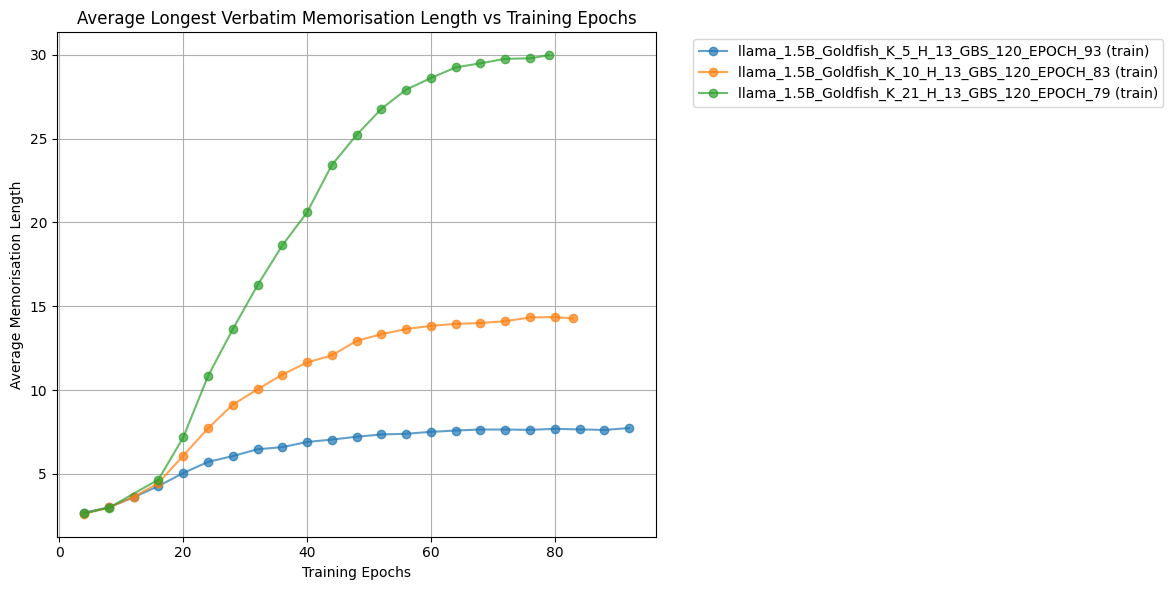

In [12]:
plot_comparison(
    results=results, 
    include_ckpts=[
        "llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93",
        "llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83",
        "llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79",
        # "llama_1.5B_Standard_GBS_120_EPOCH_75"
    ], 
    include_splits=[
        'train', 
        # 'val', 
        # 'test'
    ],
    title='Average Longest Verbatim Memorisation Length vs Training Epochs'
)

In [15]:
import pickle  # or import json
import os

# Using pickle (better for complex Python objects)
def save_results(results, save_path):
    """
    Save results dictionary to a file
    
    Parameters
    ----------
    results : dict
        Dictionary containing results
    save_path : str
        Path to save the results (e.g., 'results/data.pkl')
    """
    # Create directory if it doesn't exist
    save_dir = os.path.dirname(save_path)
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        
    with open(save_path, 'wb') as f:
        pickle.dump(results, f)

In [16]:
save_results(results, '../results/avg_lcs.pkl')

In [11]:
def calc_avg_cs_lengths(base_dir, model_ids):
    """
    Calculate average common substring lengths for multiple models with data split into train/val/test
    
    Parameters
    ----------
    base_dir : str
        Base directory containing all model results
    model_ids : list
        List of model identifiers to process
        
    Returns
    -------
    dict
        Dictionary mapping model names to their results with split information
    """
    results = {}
    for model_id in model_ids:
        expr_dir = f"{base_dir}/{model_id}"
        ckpts = get_checkpoints(expr_dir)
        
        steps, avg_lengths = [], []
        for step, consumed in tqdm(ckpts, desc=f"Processing {model_id}"):
            data = load_inference_data(expr_dir, step, consumed)
            
            # Calculate split indices
            n_total = len(data['true_suffix'])
            n_train = int(n_total * 0.9)
            n_val = int(n_total * 0.05)
            
            # Split data
            splits = {
                'train': {
                    'true_suffix': data['true_suffix'][:n_train],
                    'generated_suffix': data['generated_suffix'][:n_train]
                },
                'val': {
                    'true_suffix': data['true_suffix'][n_train:n_train + n_val],
                    'generated_suffix': data['generated_suffix'][n_train:n_train + n_val]
                },
                'test': {
                    'true_suffix': data['true_suffix'][n_train + n_val:],
                    'generated_suffix': data['generated_suffix'][n_train + n_val:]
                }
            }
            
            # Calculate CS for each split
            cs_results = {}
            for split_name, split_data in splits.items():
                cs_master = CommonSubstringMatcher(
                    split_data['true_suffix'], 
                    split_data['generated_suffix']
                )
                matches = cs_master.get_all_matches()
                # Using nanmean for samples with all None matches
                cs_results[split_name] = np.nanmean([
                    np.mean([match.length if match is not None else 0 for match in sample])
                    for sample in matches
                ])
            
            steps.append(step)
            avg_lengths.append(cs_results)
            
        # Reorganize results by split
        split_results = {
            'train': {'steps': steps, 'avg_lengths': [r['train'] for r in avg_lengths]},
            'val': {'steps': steps, 'avg_lengths': [r['val'] for r in avg_lengths]},
            'test': {'steps': steps, 'avg_lengths': [r['test'] for r in avg_lengths]}
        }
        
        results[model_id] = split_results
    
    return results

In [12]:
base_dir = "/mloscratch/homes/yixuan/PDM/inference"
model_ids = [
    "llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93",
    "llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83",
    "llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79",
    "llama_1.5B_Standard_GBS_120_EPOCH_75"
]

In [13]:
results = calc_avg_cs_lengths(base_dir, model_ids)

Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:   0%|          | 0/23 [00:00<?, ?it/s]

Computed DP matrices in 3.24 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:15<00:00, 597.48sequence/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 943.35sequence/s] 


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1087.32sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:   4%|▍         | 1/23 [00:36<13:27, 36.69s/it]

Computed DP matrices in 0.86 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:11<00:00, 786.71sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 966.25sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1187.12sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:   9%|▊         | 2/23 [01:07<11:39, 33.30s/it]

Computed DP matrices in 0.86 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:10<00:00, 897.75sequence/s] 


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 613.26sequence/s]


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1263.98sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  13%|█▎        | 3/23 [01:36<10:26, 31.31s/it]

Computed DP matrices in 0.86 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1027.57sequence/s]


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1335.38sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1447.75sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  17%|█▋        | 4/23 [02:03<09:20, 29.51s/it]

Computed DP matrices in 0.81 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1034.15sequence/s]


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1437.03sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1483.73sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  22%|██▏       | 5/23 [02:29<08:32, 28.47s/it]

Computed DP matrices in 0.87 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1025.58sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1425.60sequence/s]


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1496.86sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  26%|██▌       | 6/23 [02:57<07:56, 28.03s/it]

Computed DP matrices in 0.72 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1042.98sequence/s]


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1435.95sequence/s]


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1455.63sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  30%|███       | 7/23 [03:23<07:22, 27.63s/it]

Computed DP matrices in 0.79 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:09<00:00, 991.93sequence/s]


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1400.63sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1491.04sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  35%|███▍      | 8/23 [03:51<06:53, 27.54s/it]

Computed DP matrices in 0.82 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1037.57sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1466.41sequence/s]


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1469.63sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  39%|███▉      | 9/23 [04:18<06:22, 27.31s/it]

Computed DP matrices in 0.81 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1035.84sequence/s]


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 696.75sequence/s]


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1561.25sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  43%|████▎     | 10/23 [04:46<05:58, 27.61s/it]

Computed DP matrices in 0.80 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1079.79sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 696.28sequence/s] 


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1476.84sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  48%|████▊     | 11/23 [05:12<05:26, 27.21s/it]

Computed DP matrices in 0.70 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1057.54sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1365.04sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1495.39sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  52%|█████▏    | 12/23 [05:38<04:55, 26.90s/it]

Computed DP matrices in 0.78 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1001.37sequence/s]


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1411.18sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1462.93sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  57%|█████▋    | 13/23 [06:06<04:32, 27.21s/it]

Computed DP matrices in 0.82 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:09<00:00, 995.67sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1363.46sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1450.20sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  61%|██████    | 14/23 [06:35<04:08, 27.61s/it]

Computed DP matrices in 0.71 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1042.52sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1383.93sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1490.26sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  65%|██████▌   | 15/23 [07:03<03:42, 27.77s/it]

Computed DP matrices in 0.77 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1011.63sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1364.37sequence/s]


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1473.06sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  70%|██████▉   | 16/23 [07:30<03:12, 27.52s/it]

Computed DP matrices in 0.78 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1006.63sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1379.32sequence/s]


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1465.28sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  74%|███████▍  | 17/23 [07:58<02:46, 27.77s/it]

Computed DP matrices in 0.73 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1026.09sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 680.19sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1523.29sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  78%|███████▊  | 18/23 [08:25<02:17, 27.59s/it]

Computed DP matrices in 0.72 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1089.08sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 740.19sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1477.89sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  83%|████████▎ | 19/23 [08:53<01:49, 27.49s/it]

Computed DP matrices in 0.82 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1058.03sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1297.18sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1510.09sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  87%|████████▋ | 20/23 [09:20<01:22, 27.47s/it]

Computed DP matrices in 0.79 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1033.14sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1397.81sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1493.22sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  91%|█████████▏| 21/23 [09:47<00:54, 27.31s/it]

Computed DP matrices in 0.77 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1017.15sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1367.60sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1512.73sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  96%|█████████▌| 22/23 [10:15<00:27, 27.51s/it]

Computed DP matrices in 0.77 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1012.36sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1379.45sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1465.86sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93: 100%|██████████| 23/23 [10:42<00:00, 27.93s/it]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:   0%|          | 0/21 [00:00<?, ?it/s]

Computed DP matrices in 0.74 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:11<00:00, 797.77sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1017.14sequence/s]


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1088.37sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:   5%|▍         | 1/21 [00:30<10:11, 30.59s/it]

Computed DP matrices in 0.79 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:12<00:00, 693.85sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 921.78sequence/s]


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1030.07sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  10%|▉         | 2/21 [01:03<10:05, 31.89s/it]

Computed DP matrices in 0.82 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:10<00:00, 878.46sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1144.33sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1271.79sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  14%|█▍        | 3/21 [01:31<09:03, 30.21s/it]

Computed DP matrices in 0.81 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:09<00:00, 939.34sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1219.16sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1328.21sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  19%|█▉        | 4/21 [02:00<08:22, 29.57s/it]

Computed DP matrices in 0.78 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1062.51sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 684.99sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1441.84sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  24%|██▍       | 5/21 [02:26<07:36, 28.50s/it]

Computed DP matrices in 0.81 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1088.22sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1319.65sequence/s]


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1388.37sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  29%|██▊       | 6/21 [02:52<06:54, 27.62s/it]

Computed DP matrices in 0.80 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1039.72sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1436.82sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1530.49sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  33%|███▎      | 7/21 [03:20<06:28, 27.72s/it]

Computed DP matrices in 0.80 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1069.12sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1416.63sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1493.66sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  38%|███▊      | 8/21 [03:46<05:53, 27.18s/it]

Computed DP matrices in 0.81 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1051.15sequence/s]


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1379.82sequence/s]


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 877.20sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  43%|████▎     | 9/21 [04:14<05:29, 27.44s/it]

Computed DP matrices in 0.79 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1083.84sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1423.01sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 883.05sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  48%|████▊     | 10/21 [04:42<05:02, 27.52s/it]

Computed DP matrices in 0.83 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1029.36sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1372.62sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1478.52sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  52%|█████▏    | 11/21 [05:09<04:32, 27.30s/it]

Computed DP matrices in 0.78 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1070.42sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1374.02sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1461.53sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  57%|█████▋    | 12/21 [05:35<04:02, 26.94s/it]

Computed DP matrices in 0.78 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1029.68sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1350.00sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1498.65sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  62%|██████▏   | 13/21 [06:03<03:37, 27.24s/it]

Computed DP matrices in 0.81 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1065.87sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1372.13sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1487.48sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  67%|██████▋   | 14/21 [06:29<03:08, 26.96s/it]

Computed DP matrices in 0.83 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1052.40sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1403.30sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 926.27sequence/s] 
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  71%|███████▏  | 15/21 [06:57<02:43, 27.21s/it]

Computed DP matrices in 0.79 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1034.49sequence/s]


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1427.54sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1528.82sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  76%|███████▌  | 16/21 [07:25<02:16, 27.39s/it]

Computed DP matrices in 0.83 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1080.55sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1392.80sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1470.83sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  81%|████████  | 17/21 [07:52<01:49, 27.28s/it]

Computed DP matrices in 0.77 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1051.22sequence/s]


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1402.81sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1501.99sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  86%|████████▌ | 18/21 [08:18<01:21, 27.02s/it]

Computed DP matrices in 0.79 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1019.59sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1344.80sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1490.91sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  90%|█████████ | 19/21 [08:45<00:53, 26.97s/it]

Computed DP matrices in 0.81 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1052.80sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1363.59sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1460.82sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  95%|█████████▌| 20/21 [09:11<00:26, 26.78s/it]

Computed DP matrices in 0.79 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1048.41sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1414.63sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 870.06sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83: 100%|██████████| 21/21 [09:38<00:00, 27.55s/it]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:   0%|          | 0/19 [00:00<?, ?it/s]

Computed DP matrices in 0.81 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:10<00:00, 837.50sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1041.70sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1146.82sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:   5%|▌         | 1/19 [00:28<08:37, 28.75s/it]

Computed DP matrices in 0.79 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:11<00:00, 785.25sequence/s]


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 974.55sequence/s] 


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1133.47sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  11%|█         | 2/19 [00:59<08:28, 29.92s/it]

Computed DP matrices in 0.75 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1012.29sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 662.48sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1327.47sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  16%|█▌        | 3/19 [01:27<07:46, 29.17s/it]

Computed DP matrices in 0.78 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1057.41sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1393.36sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1395.25sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  21%|██        | 4/19 [01:53<06:59, 27.94s/it]

Computed DP matrices in 0.79 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1033.44sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1439.21sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1512.61sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  26%|██▋       | 5/19 [02:21<06:29, 27.80s/it]

Computed DP matrices in 0.79 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1077.38sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1338.59sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1460.60sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  32%|███▏      | 6/19 [02:47<05:53, 27.20s/it]

Computed DP matrices in 0.75 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1101.43sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 725.04sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1537.30sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  37%|███▋      | 7/19 [03:14<05:27, 27.27s/it]

Computed DP matrices in 0.81 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1076.42sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 682.72sequence/s] 


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1481.88sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  42%|████▏     | 8/19 [03:42<05:01, 27.45s/it]

Computed DP matrices in 0.79 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1094.22sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1398.73sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1486.92sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  47%|████▋     | 9/19 [04:09<04:33, 27.35s/it]

Computed DP matrices in 0.79 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1076.84sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1440.93sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1533.22sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  53%|█████▎    | 10/19 [04:36<04:05, 27.28s/it]

Computed DP matrices in 0.78 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1027.95sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1392.68sequence/s]


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1471.18sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  58%|█████▊    | 11/19 [05:04<03:39, 27.38s/it]

Computed DP matrices in 0.81 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1028.43sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1415.63sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1487.35sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  63%|██████▎   | 12/19 [05:31<03:11, 27.36s/it]

Computed DP matrices in 0.81 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1054.84sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1373.85sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1448.14sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  68%|██████▊   | 13/19 [05:58<02:42, 27.07s/it]

Computed DP matrices in 0.80 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1030.50sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1423.72sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1440.60sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  74%|███████▎  | 14/19 [06:25<02:16, 27.26s/it]

Computed DP matrices in 0.78 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1037.17sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1433.52sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1460.16sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  79%|███████▉  | 15/19 [06:53<01:49, 27.46s/it]

Computed DP matrices in 0.79 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1074.38sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 720.14sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1472.72sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  84%|████████▍ | 16/19 [07:20<01:21, 27.15s/it]

Computed DP matrices in 0.83 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1084.89sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1417.17sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 893.28sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  89%|████████▉ | 17/19 [07:47<00:54, 27.27s/it]

Computed DP matrices in 0.79 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1029.22sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 701.16sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1496.86sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  95%|█████████▍| 18/19 [08:15<00:27, 27.44s/it]

Computed DP matrices in 0.84 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1090.75sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1428.10sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1495.84sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79: 100%|██████████| 19/19 [08:42<00:00, 27.51s/it]
Processing llama_1.5B_Standard_GBS_120_EPOCH_75:   0%|          | 0/19 [00:00<?, ?it/s]

Computed DP matrices in 0.79 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:13<00:00, 677.09sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 797.66sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 912.32sequence/s]
Processing llama_1.5B_Standard_GBS_120_EPOCH_75:   5%|▌         | 1/19 [00:32<09:43, 32.39s/it]

Computed DP matrices in 0.74 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:11<00:00, 814.94sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1052.50sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  11%|█         | 2/19 [01:02<08:45, 30.94s/it]

Computed DP matrices in 0.77 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:10<00:00, 855.03sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1080.67sequence/s]


Computed DP matrices in 0.06 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  16%|█▌        | 3/19 [01:31<08:02, 30.18s/it]

Computed DP matrices in 0.82 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:09<00:00, 968.01sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1253.16sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  21%|██        | 4/19 [01:59<07:18, 29.25s/it]

Computed DP matrices in 0.78 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:09<00:00, 958.35sequence/s] 


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1279.40sequence/s]


Computed DP matrices in 0.06 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  26%|██▋       | 5/19 [02:28<06:48, 29.16s/it]

Computed DP matrices in 0.79 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:09<00:00, 961.06sequence/s] 


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 584.57sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  32%|███▏      | 6/19 [02:56<06:15, 28.88s/it]

Computed DP matrices in 0.80 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1029.60sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1365.90sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  37%|███▋      | 7/19 [03:23<05:39, 28.26s/it]

Computed DP matrices in 0.82 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:09<00:00, 985.45sequence/s] 


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 613.76sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  42%|████▏     | 8/19 [03:51<05:09, 28.14s/it]

Computed DP matrices in 0.80 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1082.35sequence/s]


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 644.29sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  47%|████▋     | 9/19 [04:18<04:38, 27.81s/it]

Computed DP matrices in 0.80 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1020.95sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1364.61sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  53%|█████▎    | 10/19 [04:45<04:07, 27.55s/it]

Computed DP matrices in 0.80 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:09<00:00, 988.30sequence/s] 


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1390.66sequence/s]


Computed DP matrices in 0.06 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  58%|█████▊    | 11/19 [05:13<03:41, 27.67s/it]

Computed DP matrices in 0.78 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:09<00:00, 976.69sequence/s] 


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1343.69sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  63%|██████▎   | 12/19 [05:41<03:13, 27.59s/it]

Computed DP matrices in 0.81 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1033.67sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 661.03sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  68%|██████▊   | 13/19 [06:08<02:45, 27.57s/it]

Computed DP matrices in 0.85 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1061.19sequence/s]


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1360.30sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  74%|███████▎  | 14/19 [06:35<02:16, 27.25s/it]

Computed DP matrices in 0.79 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:07<00:00, 1134.43sequence/s]


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1363.43sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  79%|███████▉  | 15/19 [07:01<01:48, 27.05s/it]

Computed DP matrices in 0.82 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:07<00:00, 1188.99sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 711.69sequence/s]


Computed DP matrices in 0.06 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  84%|████████▍ | 16/19 [07:28<01:20, 26.90s/it]

Computed DP matrices in 0.81 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:07<00:00, 1190.98sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1311.94sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  89%|████████▉ | 17/19 [07:54<00:53, 26.74s/it]

Computed DP matrices in 0.79 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:07<00:00, 1192.64sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1360.98sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  95%|█████████▍| 18/19 [08:20<00:26, 26.60s/it]

Computed DP matrices in 0.81 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:07<00:00, 1186.70sequence/s]


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1335.44sequence/s]


Computed DP matrices in 0.06 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75: 100%|██████████| 19/19 [08:47<00:00, 27.74s/it]


In [14]:
results

{'llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93': {'train': {'steps': [300,
    600,
    900,
    1200,
    1500,
    1800,
    2100,
    2400,
    2700,
    3000,
    3300,
    3600,
    3900,
    4200,
    4500,
    4800,
    5100,
    5400,
    5700,
    6000,
    6300,
    6600,
    6900],
   'avg_lengths': [2.0719532412192465,
    2.072559884328639,
    2.1004022132249447,
    2.1115800357570134,
    2.124003484161156,
    2.1317886683824314,
    2.1342808316119233,
    2.1387135438068503,
    2.1370686346004595,
    2.1408425299300826,
    2.1443681333655062,
    2.1451688477236996,
    2.1499416527876063,
    2.149531208006365,
    2.1524292288232902,
    2.15190753219568,
    2.1511123174445386,
    2.150446290532353,
    2.151549563980276,
    2.153274948808067,
    2.15417120517658,
    2.1482814291614325,
    2.1540835402787697]},
  'val': {'steps': [300,
    600,
    900,
    1200,
    1500,
    1800,
    2100,
    2400,
    2700,
    3000,
    3300,
    3600,
    3900,
   

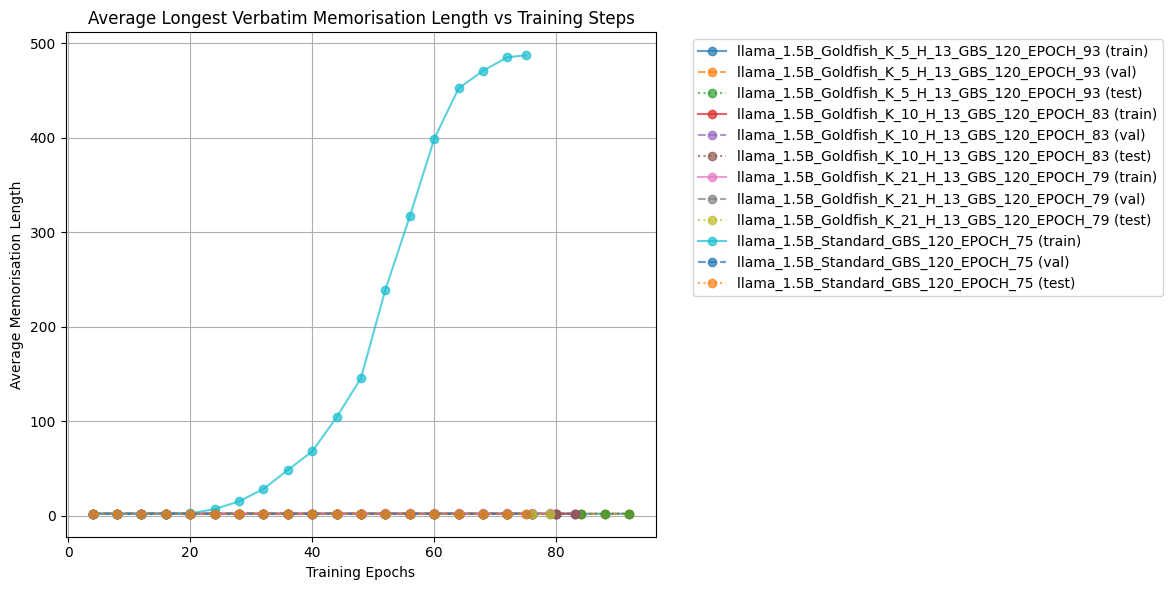

In [15]:
plot_comparison(results)

In [16]:
save_results(results, '../results/avg_cs.pkl')

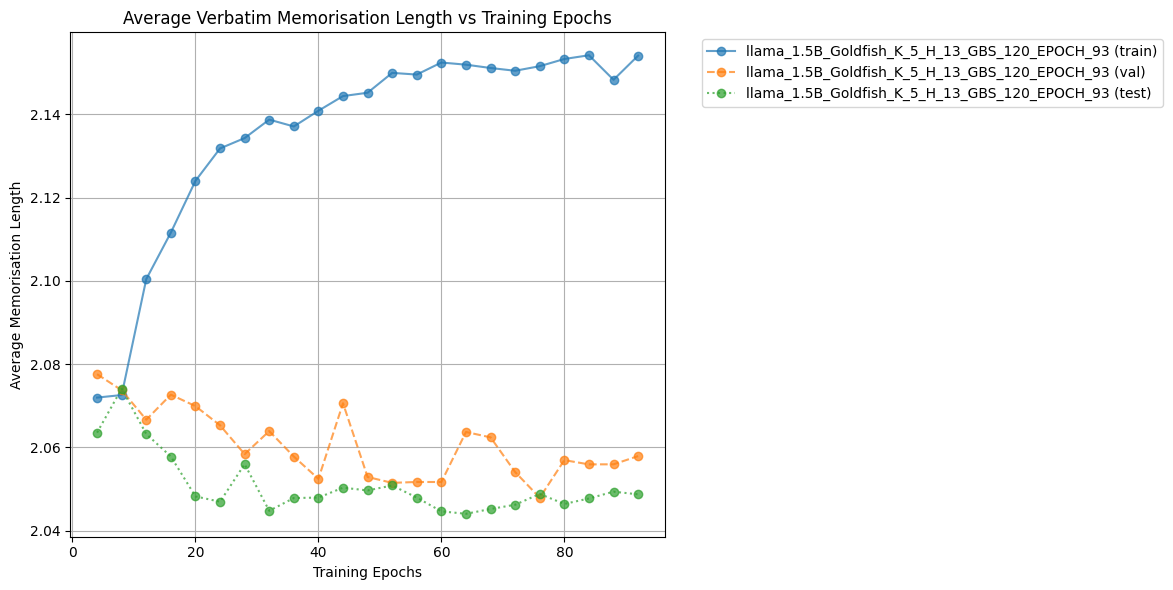

In [19]:
plot_comparison(
    results=results, 
    include_ckpts=[
        "llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93",
        # "llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83",
        # "llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79",
        # "llama_1.5B_Standard_GBS_120_EPOCH_75"
    ], 
    include_splits=[
        'train', 
        'val', 
        'test'
    ],
    title='Average Verbatim Memorisation Length vs Training Epochs'
)

In [10]:
with open('/mloscratch/homes/yixuan/PDM/results/avg_cs.pkl', 'rb') as f:
    results = pickle.load(f)